# Установка Библиотек

In [74]:
pip install pandas scikit-learn openpyxl matplotlib seaborn numpy==1.26.0 statsmodels catboost timedelta

Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [76]:
warnings.filterwarnings("ignore", category=UserWarning)

# Вывод Исходных Данных

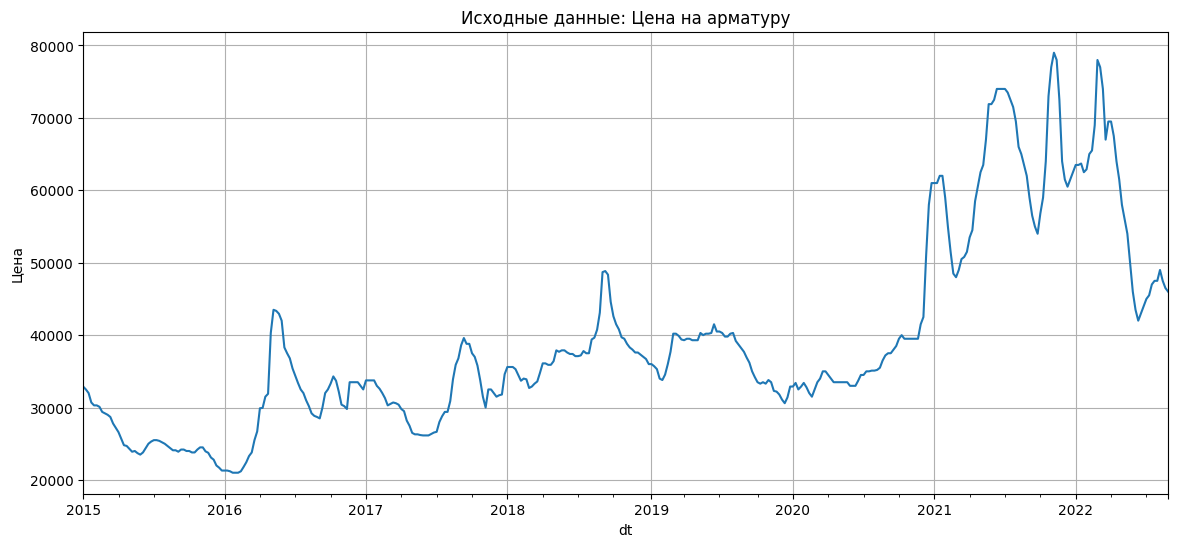

In [77]:
# Загрузка данных
df = pd.read_excel("train.xlsx")
df['dt'] = pd.to_datetime(df['dt'])
df.set_index('dt', inplace=True)


# Визуализация исходных данных
plt.figure(figsize=(14, 6))
df['Цена на арматуру'].plot(title='Исходные данные: Цена на арматуру')
plt.ylabel('Цена')
plt.grid(True)
plt.show()


# Предобработка Данных

In [78]:
# Проверка стационарности
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    return result[1] > 0.05

print("Проверка стационарности исходного ряда:")
is_non_stationary = check_stationarity(df['Цена на арматуру'])
print(f"Ряд {'не ' if is_non_stationary else ''}стационарен")

Проверка стационарности исходного ряда:
ADF Statistic: -1.9259
p-value: 0.3200
Ряд не стационарен


In [79]:
# Приведение к стационарности
df['price_diff'] = df['Цена на арматуру'].diff().dropna()
print("\nПосле дифференцирования:")
check_stationarity(df['price_diff'])



После дифференцирования:
ADF Statistic: -7.7061
p-value: 0.0000


False

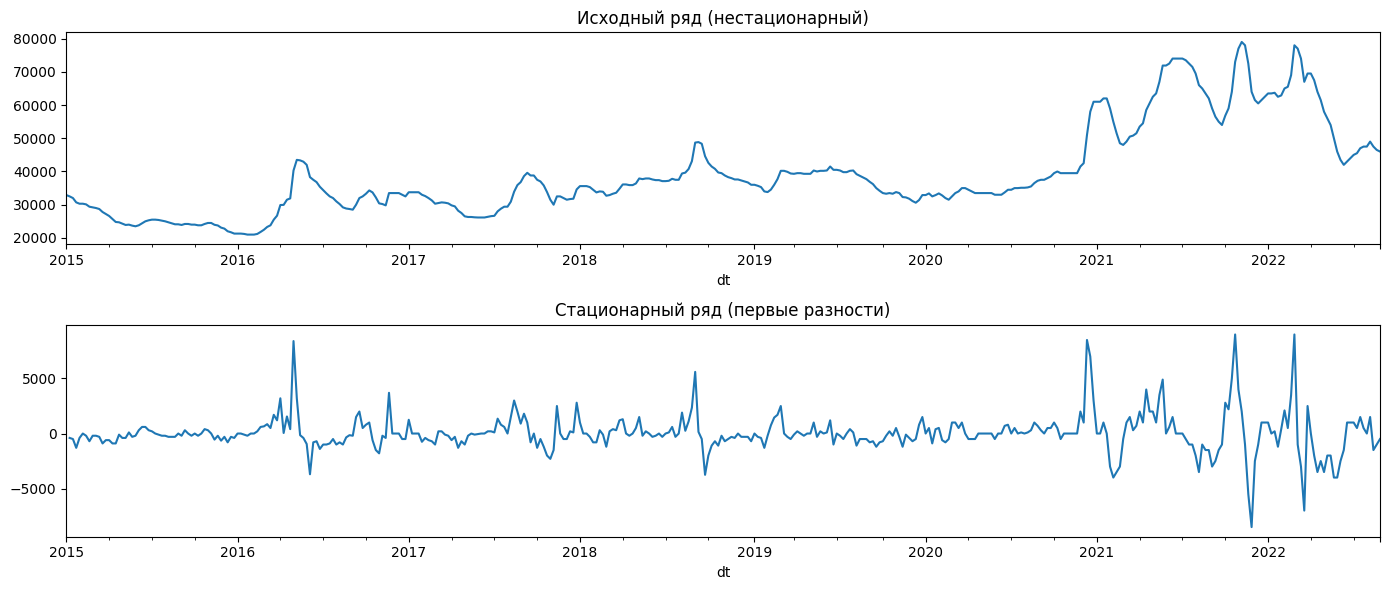

In [ ]:
# Визуализация
plt.figure(figsize=(14, 6))
plt.subplot(211)
df['Цена на арматуру'].plot(title='Исходный ряд (нестационарный)')
plt.subplot(212)
df['price_diff'].plot(title='Стационарный ряд')
plt.tight_layout()
plt.show()


# Разложение Ряда на Компоненты

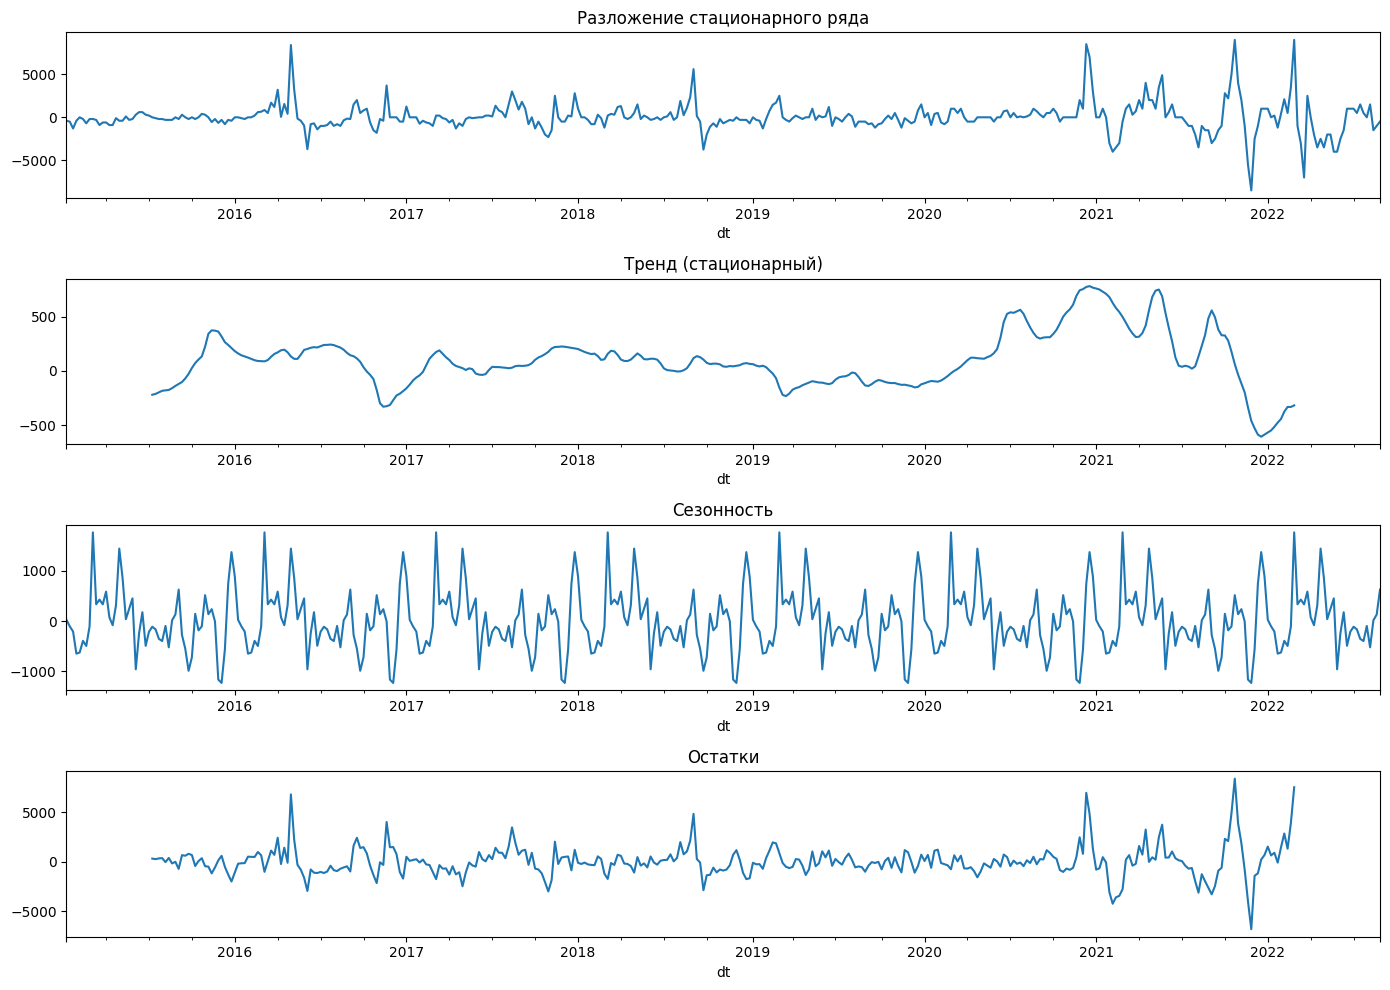

In [ ]:
# 3. Разложение стационарного ряда
decomposition = seasonal_decompose(df['price_diff'].dropna(), model='additive', period=52)

# Визуализация компонент
plt.figure(figsize=(14, 10))
plt.subplot(411)
decomposition.observed.plot(title='Разложение ряда')
plt.subplot(412)
decomposition.trend.plot(title='Тренд')
plt.subplot(413)
decomposition.seasonal.plot(title='Сезонность')
plt.subplot(414)
decomposition.resid.plot(title='Остатки')
plt.tight_layout()
plt.show()

# Сохранение компонент
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal
df['residual'] = decomposition.resid



# Создание признаков

In [82]:
# Создание признаков
def create_features(df):
    # Лаги
    for lag in [1, 2, 3, 4, 52]:
        df[f'lag_{lag}'] = df['price_diff'].shift(lag)
    
    # Скользящие статистики
    for window in [4, 12, 26]:
        df[f'rolling_mean_{window}'] = df['price_diff'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['price_diff'].rolling(window=window).std()
    
    # Временные признаки
    df['week'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    
# Взаимодействия компонент
    df['trend_seasonal'] = df['trend'] * df['seasonal']

    return df.dropna()

df = create_features(df)



In [83]:
df.to_csv("aaa.csv", index=True)

# Обучение Модели CatBoost

0:	learn: 678.0739287	test: 2214.2968738	best: 2214.2968738 (0)	total: 729us	remaining: 728ms
100:	learn: 243.1916801	test: 1288.6562678	best: 1288.6562678 (100)	total: 58.2ms	remaining: 518ms
200:	learn: 141.0682752	test: 1009.6714753	best: 1009.6714753 (200)	total: 124ms	remaining: 494ms
300:	learn: 106.4110982	test: 923.2342929	best: 923.2342929 (300)	total: 189ms	remaining: 438ms
400:	learn: 88.1429430	test: 852.7561118	best: 851.6977513 (396)	total: 259ms	remaining: 387ms
500:	learn: 76.2858393	test: 821.3118647	best: 819.9378915 (473)	total: 324ms	remaining: 322ms
600:	learn: 68.8346862	test: 803.1769181	best: 803.1769181 (600)	total: 381ms	remaining: 253ms
700:	learn: 60.7479269	test: 789.3469384	best: 788.3962760 (690)	total: 438ms	remaining: 187ms
800:	learn: 55.7915600	test: 781.1171297	best: 781.1171297 (800)	total: 500ms	remaining: 124ms
900:	learn: 51.1994396	test: 765.5844698	best: 765.3802650 (883)	total: 562ms	remaining: 61.8ms
999:	learn: 47.4629492	test: 756.2353681	b

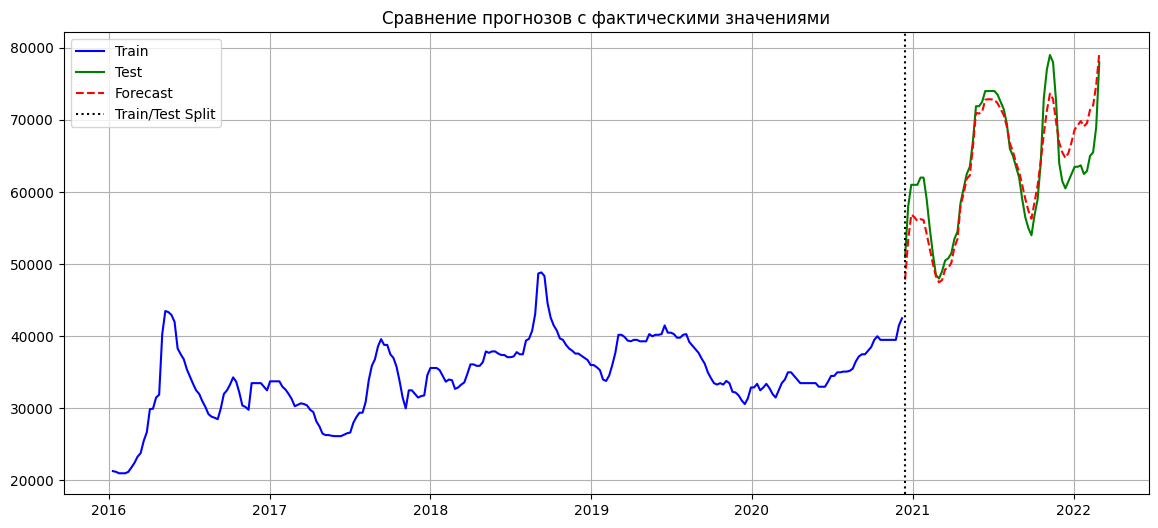

In [90]:
# Подготовка данных
X = df.drop(['Цена на арматуру', 'price_diff'], axis=1)
y = df['price_diff']


# Разделение на train/test
test_size = int(len(df) * 0.2)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Обучение модели (без визуализации в Jupyter)
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=3,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100,  
    allow_writing_files=False  
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=False)

# Функция для обратного преобразования
def inverse_transform(base_series, diff_series):
    return base_series + diff_series.cumsum()

# Прогнозирование
def make_predictions(model, X, initial_value):
    pred_diff = model.predict(X)
    pred_values = [initial_value]
    for diff in pred_diff:
        pred_values.append(pred_values[-1] + diff)
    return pd.Series(pred_values[1:], index=X.index)

initial_value = df['Цена на арматуру'].iloc[-test_size-1]
test_pred = make_predictions(model, X_test, initial_value)

# Формируем DataFrame для сохранения
predictions_df = pd.DataFrame({
    'Дата': df.index[-test_size:],  # Используем индекс как даты
    'Предсказанные значения': test_pred.values
})


# Сохраняем в CSV
predictions_df.to_csv("catboost_prediction.csv", index=False, encoding='utf-8')

print("Прогнозы сохранены в 'catboost_prediction.csv'")

# Оценка модели
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print("\nОценка на тестовой выборке:")
test_metrics = evaluate(df['Цена на арматуру'].iloc[-test_size:], test_pred)

# Визуализация прогнозов
plt.figure(figsize=(14, 6))
plt.plot(df.index[:-test_size], df['Цена на арматуру'].iloc[:-test_size], label='Train', color='blue')
plt.plot(df.index[-test_size:], df['Цена на арматуру'].iloc[-test_size:], label='Test', color='green')
plt.plot(test_pred.index, test_pred, label='Forecast', linestyle='--', color='red')
plt.axvline(df.index[-test_size], color='black', linestyle='dotted', label='Train/Test Split')
plt.title('Сравнение прогнозов с фактическими значениями')
plt.legend()
plt.grid()
plt.show()



# Сохранение Модели

In [85]:
import pickle
from catboost import CatBoostRegressor
# Сохранение модели в файл
with open("catboost_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Модель успешно сохранена в catboost_model.pkl")

Модель успешно сохранена в catboost_model.pkl
